### Import Library & Data

In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from collections import Counter

In [4]:
df = pd.read_csv('Data/PMobX_NPS_Analysis.csv')
df = df.dropna(axis=1, how='all')
df

Date                                           Feedback  \
0     7/14/2024 19:27              tidak ada fitur qris utk kartu kredit   
1     7/14/2024 19:46                                transfer gagal mulu   
2     7/14/2024 19:59  kalau ada perubahan biometrik harus registrasi...   
3     7/14/2024 20:31         bentuk aplikasi kurang menarik dan praktis   
4      7/15/2024 5:41  Kenapa transfer dibawah 1000 ditiadakan. Padah...   
...               ...                                                ...   
4012   8/27/2024 3:50  needs easier access to English speaking teleph...   
4013   8/27/2024 5:42                      masa gak bisa transfer. error   
4014   8/27/2024 6:00                                                 ok   
4015   8/27/2024 6:41                   aplikasi terkadang susah di buka   
4016   8/27/2024 6:44                                   fasilitas kurang   

     Sentiment App Related               Key Theme  \
0     Negative         Yes  Features and Promotion   
1     Negative         Yes             Reliability   
2     Negative         Yes     UI/UX and Usability   
3     Negative         Yes     UI/UX and Usability   
4     Negative         Yes          Fees and Rates   
...        ...         ...                     ...   
4012  Negative          No                Services   
4013  Negative         Yes                Services   
4014   Neutral          No                 General   
4015  Negative         Yes     UI/UX and Usability   
4016  Negative          No                Services   

                       Specific Themes  
0                     Missing Features  
1                  Failed Transactions  
2                        Complex UI/UX  
3     Application is not user-friendly  
4              Limitations on transfer  
...                                ...  
4012                  Language barrier  
4013                  Transfer failure  
4014                  Neutral feedback  
4015          App accessibility issues  
4016                Lack of facilities  

[4017 rows x 6 columns]

### 1. Cleaning Data

In [5]:
df = df[['Date', 'Feedback', 'Sentiment','Key Theme']]
df

Date                                           Feedback  \
0     7/14/2024 19:27              tidak ada fitur qris utk kartu kredit   
1     7/14/2024 19:46                                transfer gagal mulu   
2     7/14/2024 19:59  kalau ada perubahan biometrik harus registrasi...   
3     7/14/2024 20:31         bentuk aplikasi kurang menarik dan praktis   
4      7/15/2024 5:41  Kenapa transfer dibawah 1000 ditiadakan. Padah...   
...               ...                                                ...   
4012   8/27/2024 3:50  needs easier access to English speaking teleph...   
4013   8/27/2024 5:42                      masa gak bisa transfer. error   
4014   8/27/2024 6:00                                                 ok   
4015   8/27/2024 6:41                   aplikasi terkadang susah di buka   
4016   8/27/2024 6:44                                   fasilitas kurang   

     Sentiment               Key Theme  
0     Negative  Features and Promotion  
1     Negative             Reliability  
2     Negative     UI/UX and Usability  
3     Negative     UI/UX and Usability  
4     Negative          Fees and Rates  
...        ...                     ...  
4012  Negative                Services  
4013  Negative                Services  
4014   Neutral                 General  
4015  Negative     UI/UX and Usability  
4016  Negative                Services  

[4017 rows x 4 columns]

In [6]:
df.shape

(4017, 4)

In [7]:
# remove duplicates
df = df.drop_duplicates(subset='Feedback')

# remove empty rows
df = df.dropna()

df.shape

(3006, 4)

In [8]:
# Cleaning data
def clean_Feedback_data(text):
    # Remove mentions (e.g., @username)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove hashtags (e.g., #keyword)
    text = re.sub(r'#\w+', '', text)
    # Remove retweet markers (e.g., RT at the beginning of retweeted messages)
    text = re.sub(r'RT[\s]+', '', text)
    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'www.\S+', '', text)
    # Remove numbers (e.g., transaction IDs or dates)
    text = re.sub(r'\d+', '', text)
    # Remove non-alphanumeric characters (keeping only letters, numbers, and spaces)
    text = re.sub(r'[^A-Za-z0-9 ]', '', text)
    # Remove "-nya" suffix from words (both combined and separated forms)
    text = re.sub(r'\b(\w+?)\s?nya\b', r'\1', text)
    # Remove extra characters (e.g., "ssseeeppiiii" -> "sepi")
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    # Replace multiple spaces with a single space and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['Feedback'] = df['Feedback'].apply(clean_Feedback_data)

In [9]:
# lower case
df['Feedback'] = df['Feedback'].str.lower()

In [10]:
df.head(10)

Date                                           Feedback  \
0  7/14/2024 19:27              tidak ada fitur qris utk kartu kredit   
1  7/14/2024 19:46                                transfer gagal mulu   
2  7/14/2024 19:59  kalau ada perubahan biometrik harus registrasi...   
3  7/14/2024 20:31         bentuk aplikasi kurang menarik dan praktis   
4   7/15/2024 5:41  kenapa transfer dibawah ditiadakan padahal itu...   
5   7/15/2024 7:53  antrian lama bgt saat di bank harap dipercepat...   
6   7/15/2024 9:16                                         w paylorld   
7  7/15/2024 10:16                                              delay   
8  7/15/2024 13:40  i have had a lot of trouble logging into perma...   
9  7/15/2024 15:45  ga tau kenapa sekarang aplikasi lemot banget p...   

  Sentiment               Key Theme  
0  Negative  Features and Promotion  
1  Negative             Reliability  
2  Negative     UI/UX and Usability  
3  Negative     UI/UX and Usability  
4  Negative          Fees and Rates  
5  Negative                Services  
6   Neutral  Features and Promotion  
7  Negative          Ease and Speed  
8  Negative             Reliability  
9  Negative          Ease and Speed

### 2. Preprocessing

In [11]:
from deep_translator import GoogleTranslator

translator = GoogleTranslator(source='en', target='id')

df['Feedback'] = df['Feedback'].apply(lambda x: translator.translate(x))
df

Date                                           Feedback  \
0     7/14/2024 19:27              tidak ada fitur qris utk kartu kredit   
1     7/14/2024 19:46                                transfer gagal mulu   
2     7/14/2024 19:59  kalau ada perubahan biometrik harus registrasi...   
3     7/14/2024 20:31         bentuk aplikasi kurang menarik dan praktis   
4      7/15/2024 5:41  kenapa transfer dibawah ditiadakan padahal itu...   
...               ...                                                ...   
4011   8/27/2024 2:49                                      semuanya baik   
4012   8/27/2024 3:50  membutuhkan akses yang lebih mudah ke agen tel...   
4013   8/27/2024 5:42                       masa gak bisa transfer error   
4015   8/27/2024 6:41                   aplikasi terkadang susah di buka   
4016   8/27/2024 6:44                                   fasilitas kurang   

     Sentiment               Key Theme  
0     Negative  Features and Promotion  
1     Negative             Reliability  
2     Negative     UI/UX and Usability  
3     Negative     UI/UX and Usability  
4     Negative          Fees and Rates  
...        ...                     ...  
4011  Positive                 General  
4012  Negative                Services  
4013  Negative                Services  
4015  Negative     UI/UX and Usability  
4016  Negative                Services  

[3006 rows x 4 columns]

In [12]:
# import os
# import pandas as pd

# # Pastikan folder 'Data' ada
# if not os.path.exists('Data'):
#     os.makedirs('Data')

# # Simpan DataFrame ke file Excel baru di folder 'Data'
# df.to_excel('Data/data_bersih_baru.xlsx', index=False)


In [13]:
# Define a function to filter rows
def filter_tokens_by_length(dataframe, column_name, min_words, max_words):
    # Count the number of words in each entry of the specified column
    # .astype(str) ensures the data is treated as a string, even if it has other types
    words_count = dataframe[column_name].astype(str).apply(lambda x: len(x.split()))
    # Create a mask (Boolean series) that checks if the word count is within the specified range
    mask = (words_count >= min_words) & (words_count <= max_words)
    filtered_df = dataframe[mask]
    return filtered_df

# Define minimum and maximum word count for filtering
min_words = 3
max_words = 50
df = filter_tokens_by_length(df, 'Feedback', min_words, max_words)
df

Date                                           Feedback  \
0     7/14/2024 19:27              tidak ada fitur qris utk kartu kredit   
1     7/14/2024 19:46                                transfer gagal mulu   
2     7/14/2024 19:59  kalau ada perubahan biometrik harus registrasi...   
3     7/14/2024 20:31         bentuk aplikasi kurang menarik dan praktis   
4      7/15/2024 5:41  kenapa transfer dibawah ditiadakan padahal itu...   
...               ...                                                ...   
4009   8/27/2024 1:25  apk pertama sedikit berat untuk loginmohon unt...   
4010   8/27/2024 2:40  pembayaran melalui kode qr sering gagal padaha...   
4012   8/27/2024 3:50  membutuhkan akses yang lebih mudah ke agen tel...   
4013   8/27/2024 5:42                       masa gak bisa transfer error   
4015   8/27/2024 6:41                   aplikasi terkadang susah di buka   

     Sentiment               Key Theme  
0     Negative  Features and Promotion  
1     Negative             Reliability  
2     Negative     UI/UX and Usability  
3     Negative     UI/UX and Usability  
4     Negative          Fees and Rates  
...        ...                     ...  
4009  Negative     UI/UX and Usability  
4010  Negative     UI/UX and Usability  
4012  Negative                Services  
4013  Negative                Services  
4015  Negative     UI/UX and Usability  

[2439 rows x 4 columns]

In [14]:
import ast

# Load the normalization dictionary from the file
with open("Data/Combined_data.txt", "r") as kamus_file:
    norm = ast.literal_eval(kamus_file.read())

# Define the normalization function with selective replacement for 'qr'
def normalize(str_text):
    # Handle 'qr' specifically to avoid changing existing 'qris'
    words = str_text.split()  # Split text into words to process individually
    normalized_words = []
    
    for word in words:
        # Replace 'qr' with 'qris' only if it matches exactly 'qr'
        if word == "qr":
            normalized_words.append("qris")
        else:
            # Check if word is in dictionary, else use the word as is
            normalized_words.append(norm.get(word, word))
    
    return " ".join(normalized_words)

# Apply the normalization to the 'Feedback' column
df['Feedback'] = df['Feedback'].apply(normalize)


C:\Users\Andrew\AppData\Local\Temp\ipykernel_16884\1343888445.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Feedback'] = df['Feedback'].apply(normalize)


In [15]:
# Import the necessary libraries
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

# Define additional stop words (if any)
more_stop_words = []

# Initialize stop words and extend with additional stop words if needed
stop_words = StopWordRemoverFactory().get_stop_words()
stop_words.extend(more_stop_words)

# Create a custom dictionary with stop words
new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

# Define a function to remove stop words
def stopword(str_text):
    str_text = stop_words_remover_new.remove(str_text)
    return str_text

# Apply the stopword function to the 'Feedback' column using .loc to avoid the warning
df.loc[:, 'Feedback'] = df['Feedback'].apply(stopword)

# Display the DataFrame
df


C:\Users\Andrew\AppData\Local\Temp\ipykernel_16884\3705476412.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Feedback'] = df['Feedback'].apply(stopword)


Date                                           Feedback  \
0     7/14/2024 19:27                        ada fitur qris kartu kredit   
1     7/14/2024 19:46                                transfer gagal mulu   
2     7/14/2024 19:59  kalau perubahan biometrik registrasi ulang mba...   
3     7/14/2024 20:31             bentuk aplikasi kurang menarik praktis   
4      7/15/2024 5:41  transfer dibawah hapus padahal keliru satu keu...   
...               ...                                                ...   
4009   8/27/2024 1:25  aplikasi pertama sedikit berat loginmohon diup...   
4010   8/27/2024 2:40  pembayaran melalui kode qris sering gagal pada...   
4012   8/27/2024 3:50  membutuhkan akses lebih mudah agen telepon ber...   
4013   8/27/2024 5:42                           masa bisa transfer error   
4015   8/27/2024 6:41                      aplikasi terkadang susah buka   

     Sentiment               Key Theme  
0     Negative  Features and Promotion  
1     Negative             Reliability  
2     Negative     UI/UX and Usability  
3     Negative     UI/UX and Usability  
4     Negative          Fees and Rates  
...        ...                     ...  
4009  Negative     UI/UX and Usability  
4010  Negative     UI/UX and Usability  
4012  Negative                Services  
4013  Negative                Services  
4015  Negative     UI/UX and Usability  

[2439 rows x 4 columns]

In [16]:
#Tokenization
tokenized = df['Feedback'].apply(lambda x: x.split())
tokenized


0                       [ada, fitur, qris, kartu, kredit]
1                                 [transfer, gagal, mulu]
2       [kalau, perubahan, biometrik, registrasi, ulan...
3            [bentuk, aplikasi, kurang, menarik, praktis]
4       [transfer, dibawah, hapus, padahal, keliru, sa...
                              ...                        
4009    [aplikasi, pertama, sedikit, berat, loginmohon...
4010    [pembayaran, melalui, kode, qris, sering, gaga...
4012    [membutuhkan, akses, lebih, mudah, agen, telep...
4013                        [masa, bisa, transfer, error]
4015                   [aplikasi, terkadang, susah, buka]
Name: Feedback, Length: 2439, dtype: object

In [17]:
#Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(text_cleaning):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    do = []
    for w in text_cleaning:
        dt = stemmer.stem(w)
        do.append(dt)
    d_clean = " ".join(do)
    print(d_clean)
    return d_clean

tokenized = tokenized.apply(stemming)

ada fitur qris kartu kredit
transfer gagal mulu
kalau ubah biometrik registrasi ulang mbanking awal bener bener repot aplikasi bank jika ubah biometrik cukup aktif ulang sidik jari registrasi ulang mbanking
bentuk aplikasi kurang tarik praktis
transfer bawah hapus padahal keliru satu unggul permata banding bank
antri lama banget di bank harap cepat layan
w kuasa gaji
alami banyak kendala login mobile perban permata sistem muncul pesan kata permata x sedang alami kendala teknis kami coba nanti sangat sebal saya bayar qris depan sewa
ga tau sekarang aplikasi lambat banget padahal jaring bagus stabil mohon baik
layan bagus nyaman tahan
sering error kalau qris bisa langsung nyantol sering konek kalau bca selalu oke
pernah d acc pinjam kta padahal gaji lewat permata bayar kta lancar malah habis bayar sampe sekarang tahun pernah acc pinjam
data invest bond tidak akurat data detail
login email transaksi sangat mengangu
riwayat transaksi bagus dulu periode pilih default jadi hemat langkah kalo

### 3. Labeling

In [18]:
df.head(10)

Date                                           Feedback  \
0   7/14/2024 19:27                        ada fitur qris kartu kredit   
1   7/14/2024 19:46                                transfer gagal mulu   
2   7/14/2024 19:59  kalau perubahan biometrik registrasi ulang mba...   
3   7/14/2024 20:31             bentuk aplikasi kurang menarik praktis   
4    7/15/2024 5:41  transfer dibawah hapus padahal keliru satu keu...   
5    7/15/2024 7:53  antrian lama banget di bank harap dipercepat p...   
6    7/15/2024 9:16                                    w penguasa gaji   
8   7/15/2024 13:40  mengalami banyak kendala login mobile perbanka...   
9   7/15/2024 15:45  ga tau sekarang aplikasi lambat banget padahal...   
10  7/15/2024 16:11               pelayanan bagus nyaman dipertahankan   

   Sentiment               Key Theme  
0   Negative  Features and Promotion  
1   Negative             Reliability  
2   Negative     UI/UX and Usability  
3   Negative     UI/UX and Usability  
4   Negative          Fees and Rates  
5   Negative                Services  
6    Neutral  Features and Promotion  
8   Negative             Reliability  
9   Negative          Ease and Speed  
10  Positive                Services

In [19]:
# show stemmed dataframe
# Convert the 'Date' column to datetime format and keep only the date
df['Date'] = pd.to_datetime(df['Date']).dt.date
df_stem = pd.DataFrame({'Date': df['Date'],'Feedback': tokenized, 'Sentiment': df['Sentiment'], 'Key Theme': df['Key Theme']})
df_stem

C:\Users\Andrew\AppData\Local\Temp\ipykernel_16884\4240001376.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Date                                           Feedback Sentiment  \
0     2024-07-14                        ada fitur qris kartu kredit  Negative   
1     2024-07-14                                transfer gagal mulu  Negative   
2     2024-07-14  kalau ubah biometrik registrasi ulang mbanking...  Negative   
3     2024-07-14               bentuk aplikasi kurang tarik praktis  Negative   
4     2024-07-15  transfer bawah hapus padahal keliru satu unggu...  Negative   
...          ...                                                ...       ...   
4009  2024-08-27  aplikasi pertama sedikit berat loginmohon diup...  Negative   
4010  2024-08-27  bayar lalu kode qris sering gagal padahal jari...  Negative   
4012  2024-08-27  butuh akses lebih mudah agen telepon bahasa in...  Negative   
4013  2024-08-27                           masa bisa transfer error  Negative   
4015  2024-08-27                      aplikasi terkadang susah buka  Negative   

                   Key Theme  
0     Features and Promotion  
1                Reliability  
2        UI/UX and Usability  
3        UI/UX and Usability  
4             Fees and Rates  
...                      ...  
4009     UI/UX and Usability  
4010     UI/UX and Usability  
4012                Services  
4013                Services  
4015     UI/UX and Usability  

[2439 rows x 4 columns]

### Data Preprocessed

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from collections import Counter

In [3]:
import pandas as pd

# Load the CSV file back into a DataFrame
df_stem = pd.read_csv('Data/data_preprocessing.csv')

# Display the DataFrame to verify
df_stem

Date                                           Feedback Sentiment  \
0     2024-07-14                        ada fitur qris kartu kredit  Negative   
1     2024-07-14                                transfer gagal mulu  Negative   
2     2024-07-14  kalau ubah biometrik registrasi ulang mobile b...  Negative   
3     2024-07-14               bentuk aplikasi kurang tarik praktis  Negative   
4     2024-07-15  transfer bawah hapus padahal keliru satu unggu...  Negative   
...          ...                                                ...       ...   
2434  2024-08-27  aplikasi pertama sedikit berat loginmohon diup...  Negative   
2435  2024-08-27  bayar lalu kode qris sering gagal padahal jari...  Negative   
2436  2024-08-27  butuh akses lebih mudah agen telepon bahasa in...  Negative   
2437  2024-08-27                           masa bisa transfer error  Negative   
2438  2024-08-27                      aplikasi terkadang susah buka  Negative   

                   Key Theme  
0     Features and Promotion  
1                Reliability  
2        UI/UX and Usability  
3        UI/UX and Usability  
4             Fees and Rates  
...                      ...  
2434     UI/UX and Usability  
2435     UI/UX and Usability  
2436                Services  
2437                Services  
2438     UI/UX and Usability  

[2439 rows x 4 columns]

In [4]:
# show count all positive, negative, neutral
df_countSent = df_stem['Sentiment'].value_counts()
df_countSent

Negative    1897
Positive     404
Neutral      138
Name: Sentiment, dtype: int64

In [5]:
# show count all Categories
df_countKey = df_stem['Key Theme'].value_counts()
df_countKey

Services                  591
Ease and Speed            405
Features and Promotion    399
UI/UX and Usability       312
Reliability               290
General                   235
Fees and Rates            207
Name: Key Theme, dtype: int64

### 4. Visualization

In [6]:
# Data positive, negative, neutral
df_positive = df_stem[df_stem['Sentiment'] == 'Positive']
df_negative = df_stem[df_stem['Sentiment'] == 'Negative']
df_neutral = df_stem[df_stem['Sentiment'] == 'Neutral']

In [7]:
# Data Categories
df_services = df_stem[df_stem['Key Theme'] == 'Services']
df_reliability = df_stem[df_stem['Key Theme'] == 'Reliability']
df_features = df_stem[df_stem['Key Theme'] == 'Features and Promotion']
df_speed = df_stem[df_stem['Key Theme'] == 'Ease and Speed']
df_general = df_stem[df_stem['Key Theme'] == 'General']
df_uiux = df_stem[df_stem['Key Theme'] == 'UI/UX and Usability']
df_fees = df_stem[df_stem['Key Theme'] == 'Fees and Rates']

In [8]:
# WordCloud for each key themes and sentiment
from wordcloud import WordCloud

def generate_wordcloud (df, sentiment):
    text = " ".join(df['Feedback'].astype(str))  # Combine all feedback text
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment} Sentiment")
    plt.show()

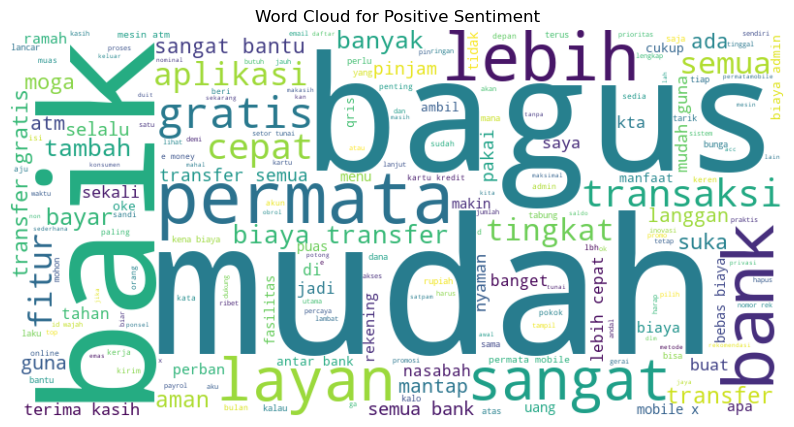

In [9]:
# Generate word clouds for positive
generate_wordcloud(df_positive, "Positive")

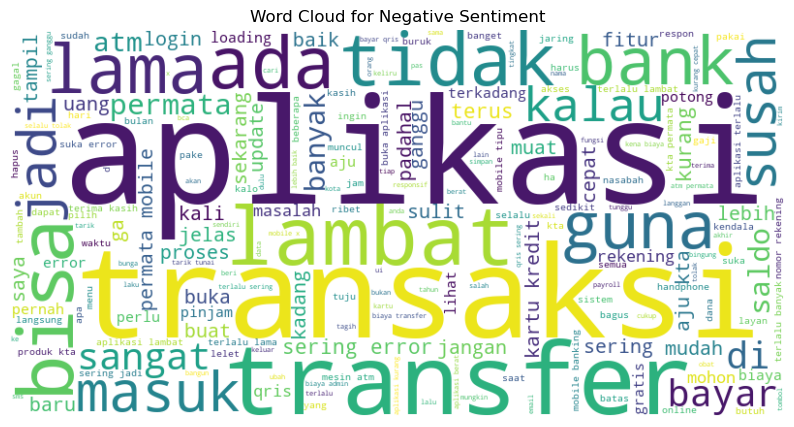

In [10]:
# Generate word clouds for negative
generate_wordcloud(df_negative, "Negative")

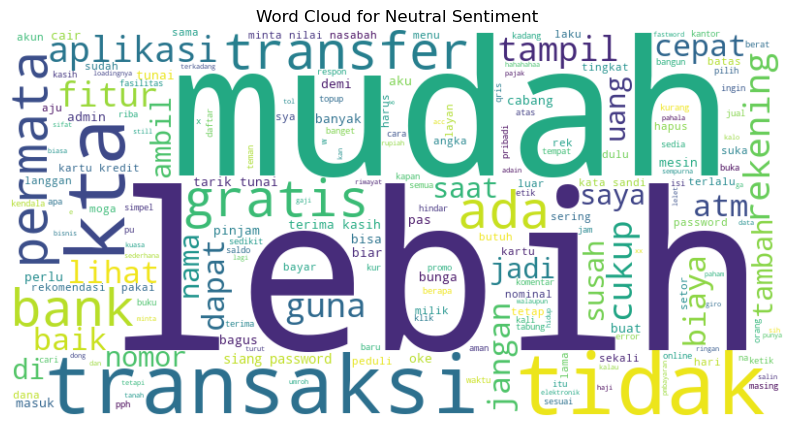

In [11]:
# Generate word clouds for neutral
generate_wordcloud(df_neutral, "Neutral")

In [12]:
def generate_wordclouds_by_theme_and_sentiment(df):
    key_themes = df['Key Theme'].unique()  # Get unique key themes
    sentiments = df['Sentiment'].unique()  # Get unique sentiments
    
    for theme in key_themes:
        for sentiment in sentiments:
            # Filter data for the current theme and sentiment
            filtered_data = df[(df['Key Theme'] == theme) & (df['Sentiment'] == sentiment)]
            
            if not filtered_data.empty:  # Proceed only if there is data for the combination
                text = " ".join(filtered_data['Feedback'].astype(str))  # Combine feedback text
                
                # Generate the WordCloud
                wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
                
                # Plot the WordCloud
                plt.figure(figsize=(10, 6))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis("off")
                plt.title(f"Word Cloud for {theme} ({sentiment} Sentiment)")
                plt.show()

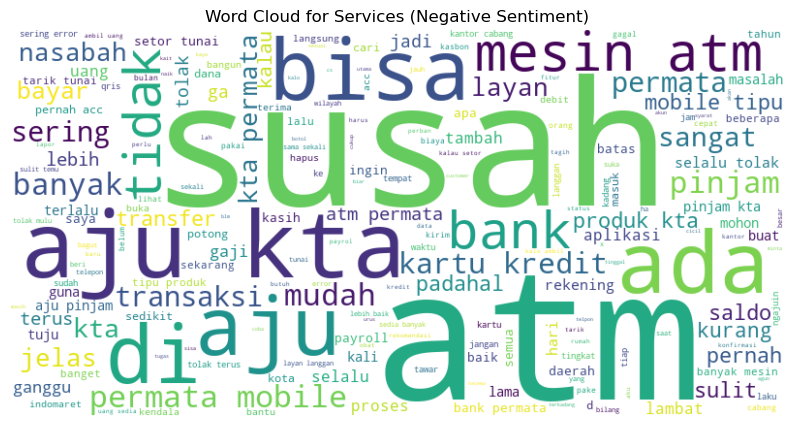

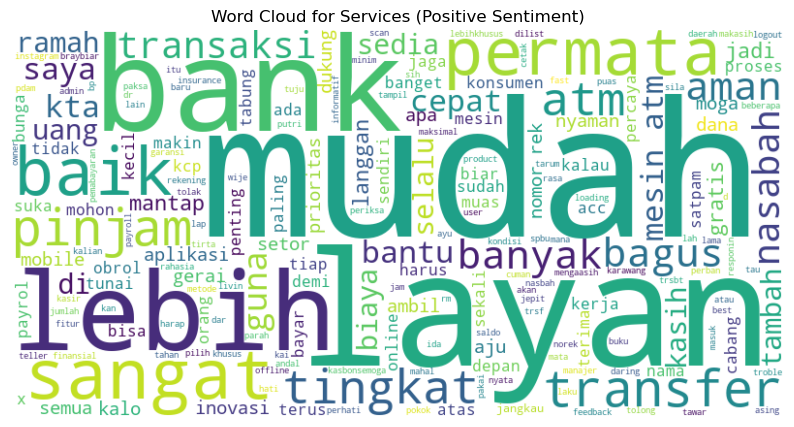

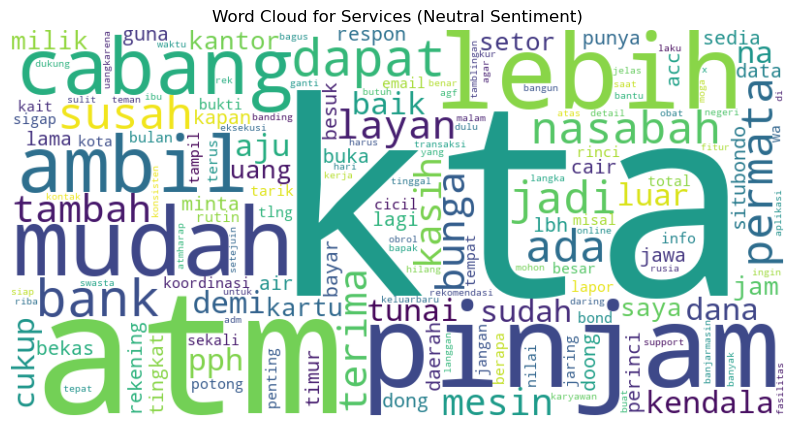

In [13]:
# Generate word clouds for Services and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_services)



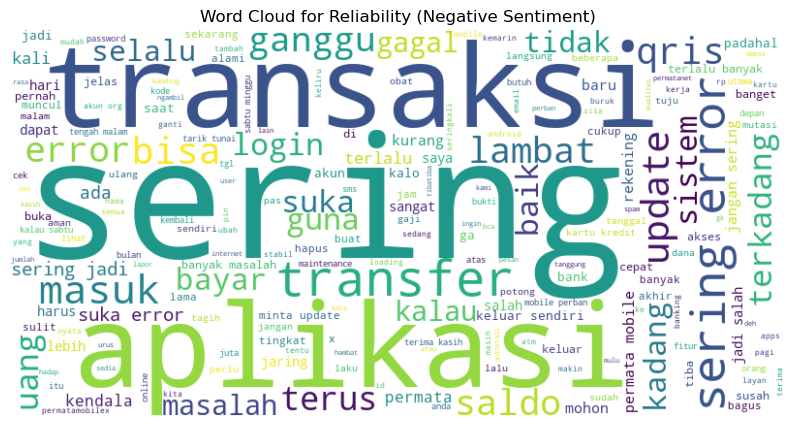

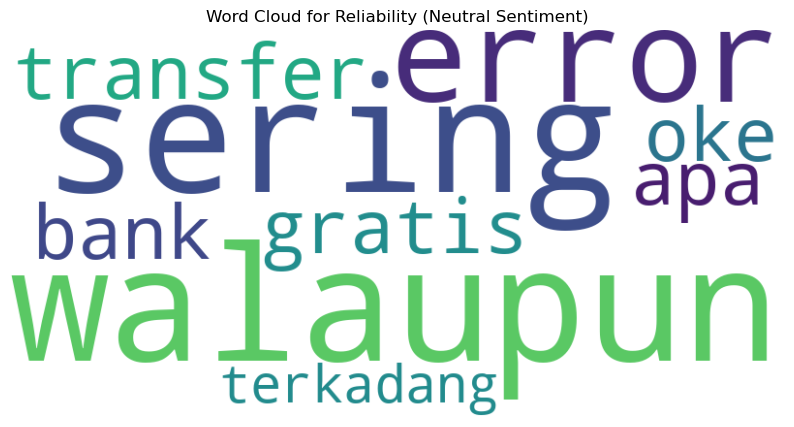

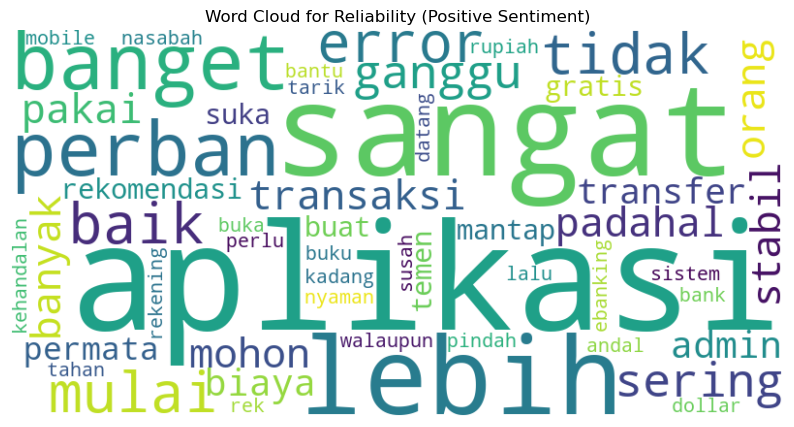

In [14]:
# Generate word clouds for Reliability and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_reliability)

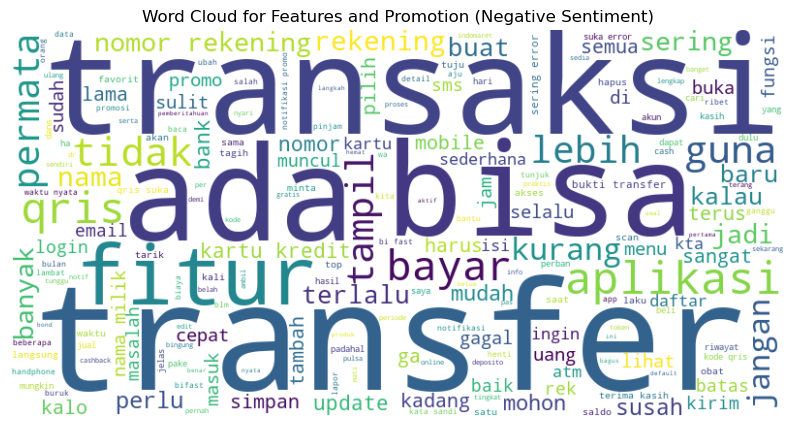

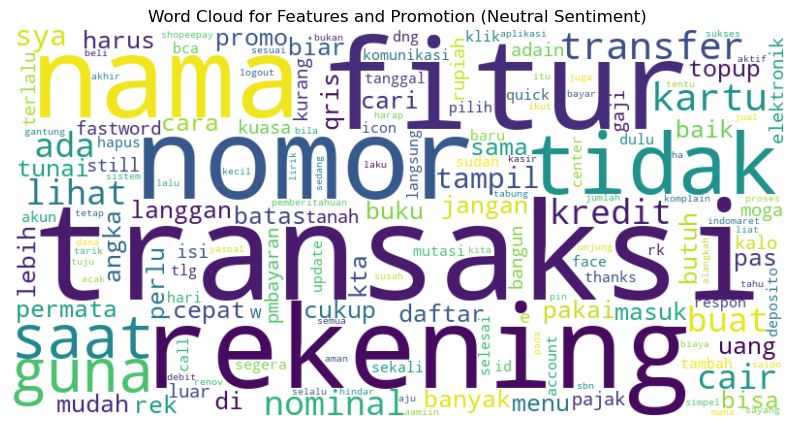

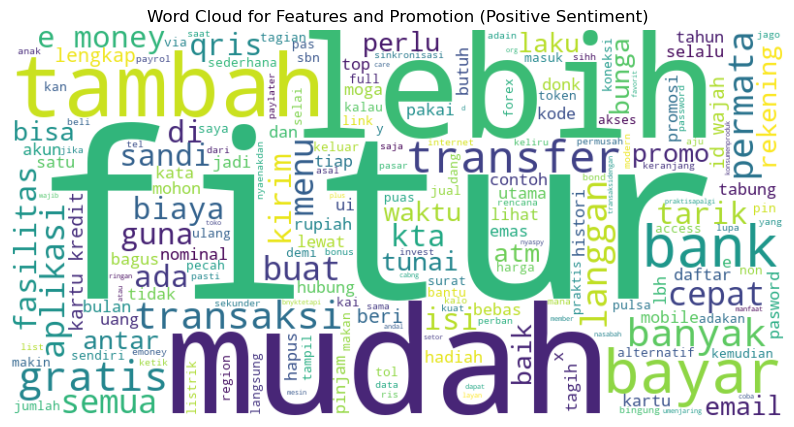

In [15]:
# Generate word clouds for Features and Promotion and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_features)

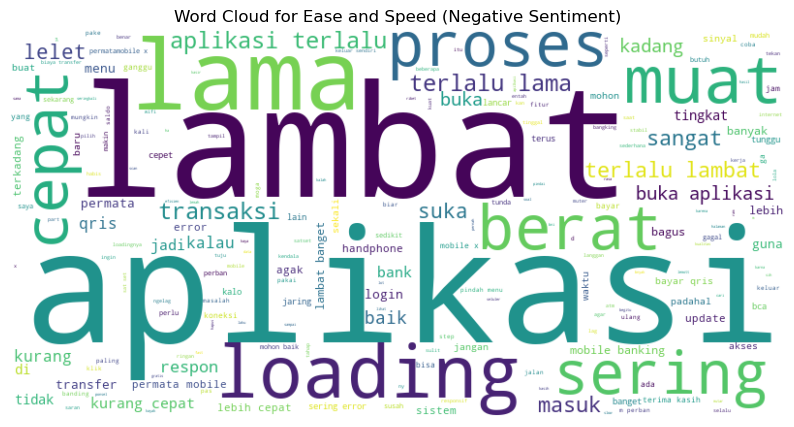

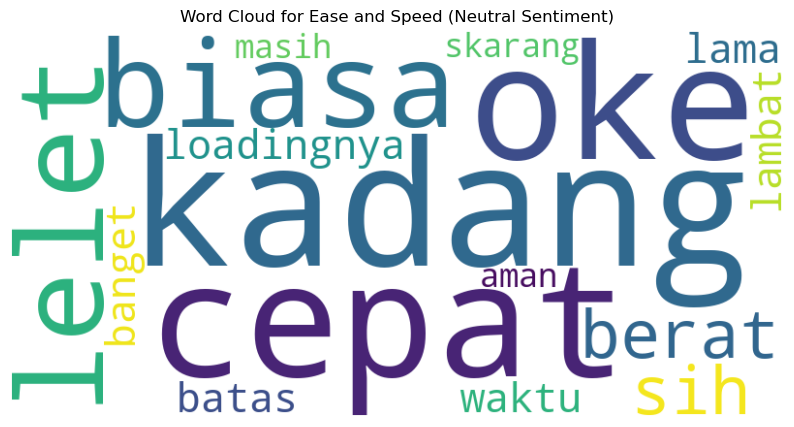

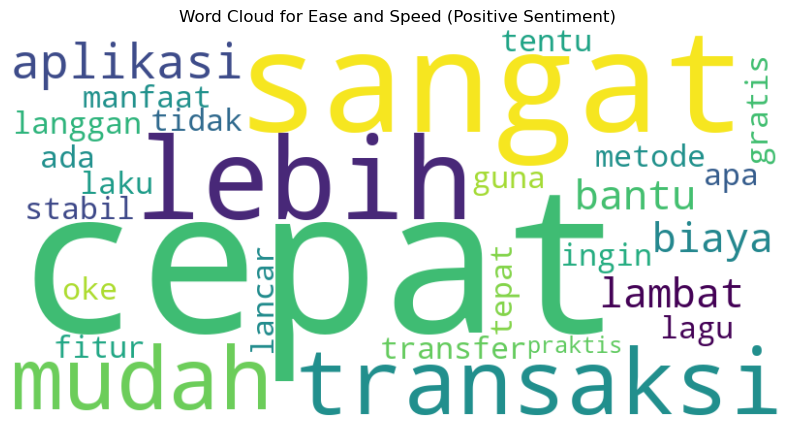

In [16]:
# Generate word clouds for Speed and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_speed)

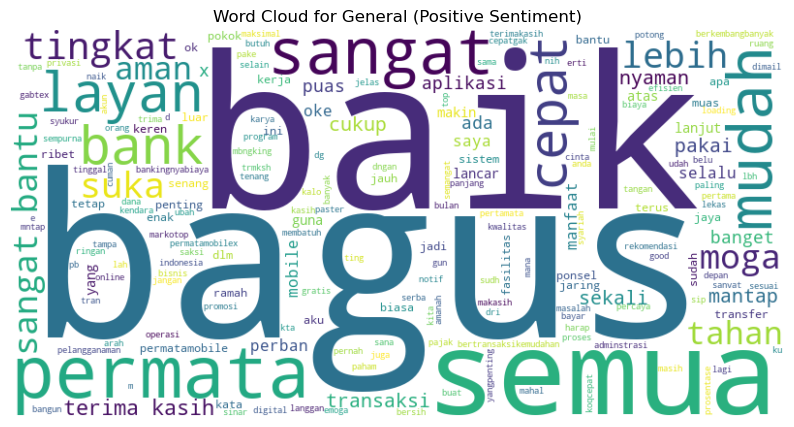

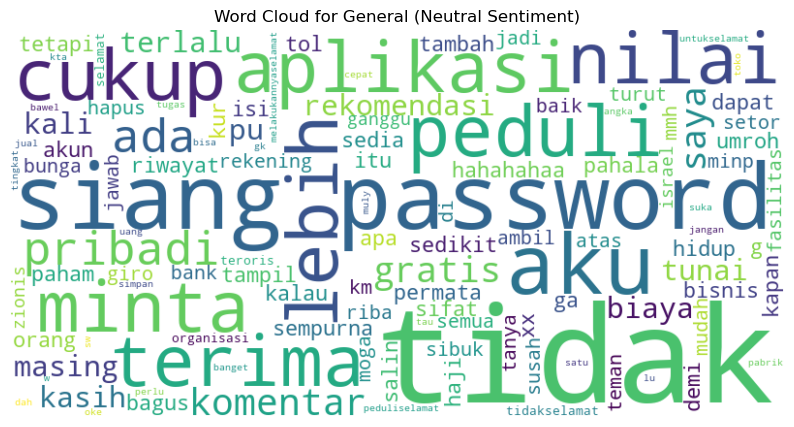

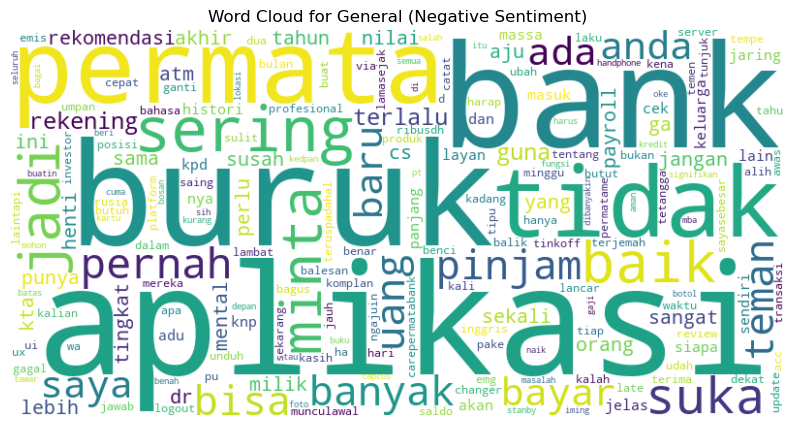

In [17]:
# Generate word clouds for General and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_general)

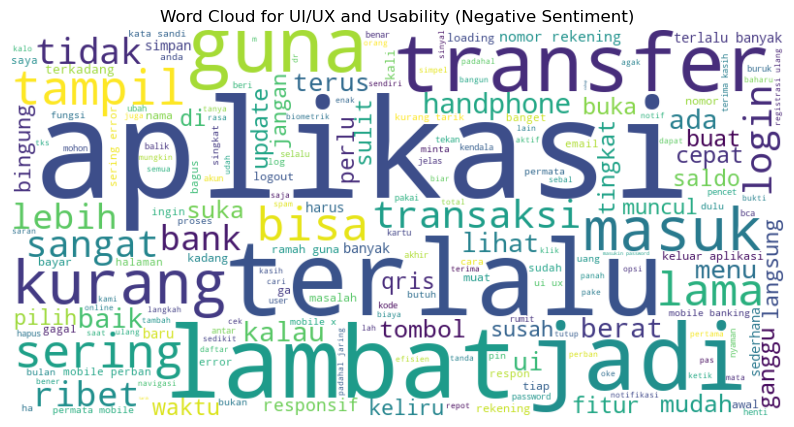

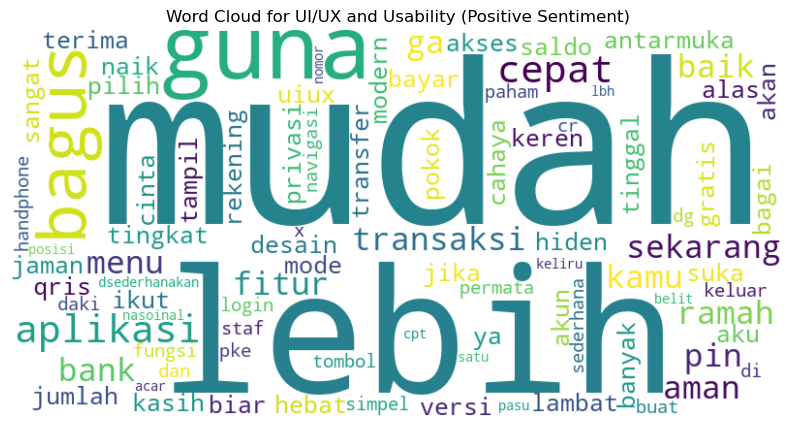

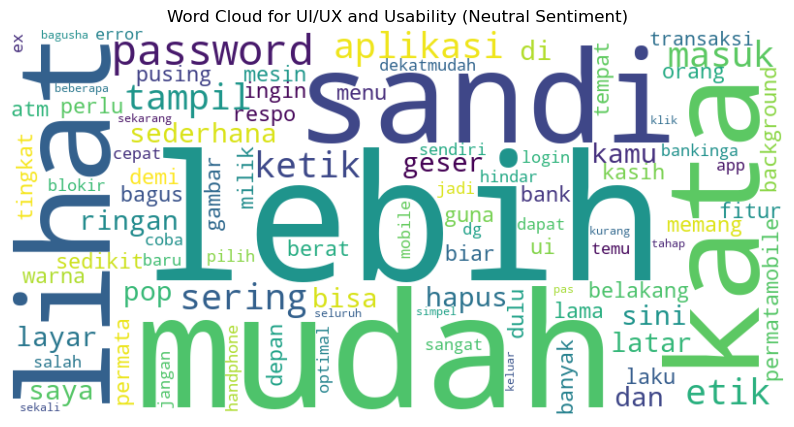

In [18]:
# Generate word clouds for UI/UX and Usability and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_uiux)

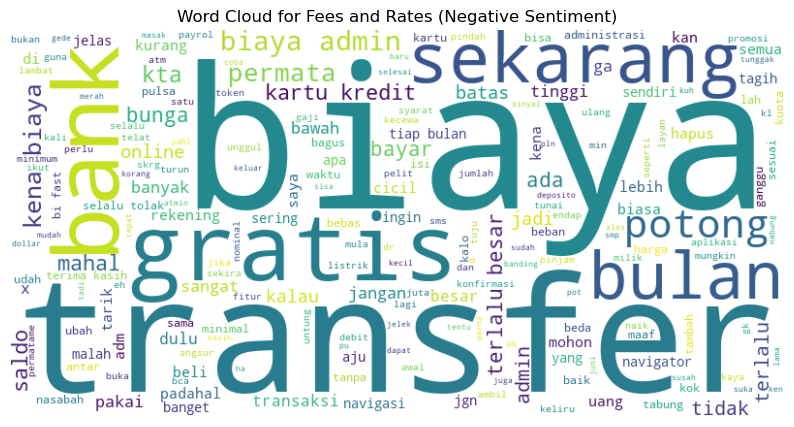

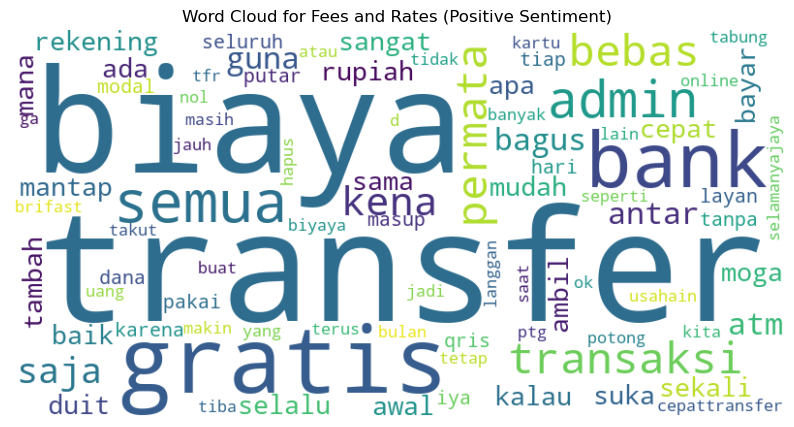

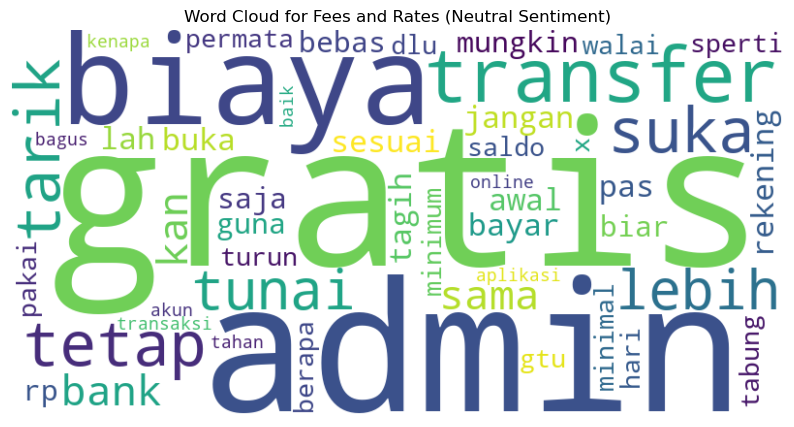

In [19]:
# Generate word clouds for Fees and Rates and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_fees)

### 5. Prepare Data Training

### 6. Training Data

In [20]:
df_stem

Date                                           Feedback Sentiment  \
0     2024-07-14                        ada fitur qris kartu kredit  Negative   
1     2024-07-14                                transfer gagal mulu  Negative   
2     2024-07-14  kalau ubah biometrik registrasi ulang mobile b...  Negative   
3     2024-07-14               bentuk aplikasi kurang tarik praktis  Negative   
4     2024-07-15  transfer bawah hapus padahal keliru satu unggu...  Negative   
...          ...                                                ...       ...   
2434  2024-08-27  aplikasi pertama sedikit berat loginmohon diup...  Negative   
2435  2024-08-27  bayar lalu kode qris sering gagal padahal jari...  Negative   
2436  2024-08-27  butuh akses lebih mudah agen telepon bahasa in...  Negative   
2437  2024-08-27                           masa bisa transfer error  Negative   
2438  2024-08-27                      aplikasi terkadang susah buka  Negative   

                   Key Theme  
0     Features and Promotion  
1                Reliability  
2        UI/UX and Usability  
3        UI/UX and Usability  
4             Fees and Rates  
...                      ...  
2434     UI/UX and Usability  
2435     UI/UX and Usability  
2436                Services  
2437                Services  
2438     UI/UX and Usability  

[2439 rows x 4 columns]

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import pandas as pd

# Encode labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_stem['Key Theme'])

# Split data into train and test sets
X = df_stem['Feedback']
y = y_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Define classifiers and hyperparameters
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', random_state=42, class_weight='balanced')
}

# Store results
resultsCV = []

# Train and evaluate each classifier
for clf_name, clf in classifiers.items():
    print(f"Training {clf_name}...")
    
    # Train the classifier
    clf.fit(X_train_vectorized, y_train)
    
    # Predict on test data
    y_pred = clf.predict(X_test_vectorized)
    
    # Calculate metrics for overall performance
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')


    # Evaluate metrics for each category
    for category in label_encoder.classes_:
        category_idx = label_encoder.transform([category])[0]
        y_test_category = (y_test == category_idx).astype(int)
        y_pred_category = (y_pred == category_idx).astype(int)

        category_accuracy = accuracy_score(y_test_category, y_pred_category)
        category_recall = recall_score(y_test_category, y_pred_category)
        category_precision = precision_score(y_test_category, y_pred_category)
        category_f1 = f1_score(y_test_category, y_pred_category)

        # Append category-specific metrics
        resultsCV.append({
            'Category': category,
            'Classifier': clf_name,
            'Accuracy': category_accuracy,
            'Recall': category_recall,
            'Precision': category_precision,
            'F1 Score': category_f1
        })

# Convert results to DataFrame for easy display
df_resultsCV = pd.DataFrame(resultsCV)

# Display overall results
df_resultsCV


Training KNN...
Training Random Forest...
Training Naive Bayes...
Training SVM...


Category     Classifier  Accuracy    Recall  Precision  \
0           Ease and Speed            KNN  0.852459  0.802469   0.537190   
1   Features and Promotion            KNN  0.797131  0.425000   0.390805   
2           Fees and Rates            KNN  0.956967  0.682927   0.777778   
3                  General            KNN  0.823770  0.702128   0.314286   
4              Reliability            KNN  0.879098  0.293103   0.485714   
5                 Services            KNN  0.823770  0.483051   0.695122   
6      UI/UX and Usability            KNN  0.875000  0.190476   0.545455   
7           Ease and Speed  Random Forest  0.893443  0.827160   0.638095   
8   Features and Promotion  Random Forest  0.819672  0.487500   0.453488   
9           Fees and Rates  Random Forest  0.961066  0.731707   0.789474   
10                 General  Random Forest  0.901639  0.617021   0.491525   
11             Reliability  Random Forest  0.864754  0.396552   0.425926   
12                Services  Random Forest  0.862705  0.686441   0.729730   
13     UI/UX and Usability  Random Forest  0.885246  0.333333   0.600000   
14          Ease and Speed    Naive Bayes  0.920082  0.839506   0.723404   
15  Features and Promotion    Naive Bayes  0.852459  0.562500   0.548780   
16          Fees and Rates    Naive Bayes  0.967213  0.707317   0.878788   
17                 General    Naive Bayes  0.903689  0.191489   0.500000   
18             Reliability    Naive Bayes  0.879098  0.500000   0.491525   
19                Services    Naive Bayes  0.834016  0.796610   0.622517   
20     UI/UX and Usability    Naive Bayes  0.877049  0.428571   0.529412   
21          Ease and Speed            SVM  0.901639  0.753086   0.685393   
22  Features and Promotion            SVM  0.811475  0.562500   0.441176   
23          Fees and Rates            SVM  0.961066  0.731707   0.789474   
24                 General            SVM  0.905738  0.617021   0.508772   
25             Reliability            SVM  0.862705  0.396552   0.418182   
26                Services            SVM  0.852459  0.618644   0.730000   
27     UI/UX and Usability            SVM  0.864754  0.349206   0.468085   

    F1 Score  
0   0.643564  
1   0.407186  
2   0.727273  
3   0.434211  
4   0.365591  
5   0.570000  
6   0.282353  
7   0.720430  
8   0.469880  
9   0.759494  
10  0.547170  
11  0.410714  
12  0.707424  
13  0.428571  
14  0.777143  
15  0.555556  
16  0.783784  
17  0.276923  
18  0.495726  
19  0.698885  
20  0.473684  
21  0.717647  
22  0.494505  
23  0.759494  
24  0.557692  
25  0.407080  
26  0.669725  
27  0.400000

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import pandas as pd

# Encode labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_stem['Key Theme'])

# Split data into train and test sets
X = df_stem['Feedback']
y = y_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Apply SMOTE to handle imbalanced data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_vectorized, y_train)

# Define classifiers
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', random_state=42, class_weight='balanced')
}

# Store results
resultsCVS = []

# Train and evaluate each classifier
for clf_name, clf in classifiers.items():
    print(f"Training {clf_name}...")
    clf.fit(X_train_smote, y_train_smote)
    y_pred = clf.predict(X_test_vectorized)
    
    # Evaluate metrics for each category
    for category_idx, category in enumerate(label_encoder.classes_):
        y_test_category = (y_test == category_idx).astype(int)
        y_pred_category = (y_pred == category_idx).astype(int)
        
        category_accuracy = accuracy_score(y_test_category, y_pred_category)
        category_recall = recall_score(y_test_category, y_pred_category)
        category_precision = precision_score(y_test_category, y_pred_category)
        category_f1 = f1_score(y_test_category, y_pred_category)
        
        # Append results
        resultsCVS.append({
            'Category': category,
            'Classifier': clf_name,
            'Accuracy': category_accuracy,
            'Recall': category_recall,
            'Precision': category_precision,
            'F1 Score': category_f1
        })

# Convert results to a DataFrame for easy display
df_resultsCVS = pd.DataFrame(resultsCVS)

# Display overall results
df_resultsCVS


Training KNN...
Training Random Forest...
Training Naive Bayes...
Training SVM...


Category     Classifier  Accuracy    Recall  Precision  \
0           Ease and Speed            KNN  0.905738  0.703704   0.721519   
1   Features and Promotion            KNN  0.803279  0.462500   0.411111   
2           Fees and Rates            KNN  0.930328  0.829268   0.557377   
3                  General            KNN  0.842213  0.595745   0.325581   
4              Reliability            KNN  0.827869  0.448276   0.333333   
5                 Services            KNN  0.836066  0.338983   0.952381   
6      UI/UX and Usability            KNN  0.846311  0.317460   0.384615   
7           Ease and Speed  Random Forest  0.915984  0.765432   0.738095   
8   Features and Promotion  Random Forest  0.801230  0.462500   0.406593   
9           Fees and Rates  Random Forest  0.954918  0.829268   0.693878   
10                 General  Random Forest  0.909836  0.638298   0.526316   
11             Reliability  Random Forest  0.848361  0.500000   0.391892   
12                Services  Random Forest  0.875000  0.550847   0.890411   
13     UI/UX and Usability  Random Forest  0.850410  0.396825   0.416667   
14          Ease and Speed    Naive Bayes  0.928279  0.814815   0.767442   
15  Features and Promotion    Naive Bayes  0.850410  0.562500   0.542169   
16          Fees and Rates    Naive Bayes  0.965164  0.780488   0.800000   
17                 General    Naive Bayes  0.920082  0.531915   0.595238   
18             Reliability    Naive Bayes  0.868852  0.568966   0.458333   
19                Services    Naive Bayes  0.875000  0.694915   0.766355   
20     UI/UX and Usability    Naive Bayes  0.879098  0.492063   0.534483   
21          Ease and Speed            SVM  0.899590  0.740741   0.681818   
22  Features and Promotion            SVM  0.809426  0.550000   0.435644   
23          Fees and Rates            SVM  0.950820  0.731707   0.697674   
24                 General            SVM  0.920082  0.595745   0.583333   
25             Reliability            SVM  0.866803  0.482759   0.444444   
26                Services            SVM  0.860656  0.618644   0.760417   
27     UI/UX and Usability            SVM  0.868852  0.380952   0.489796   

    F1 Score  
0   0.712500  
1   0.435294  
2   0.666667  
3   0.421053  
4   0.382353  
5   0.500000  
6   0.347826  
7   0.751515  
8   0.432749  
9   0.755556  
10  0.576923  
11  0.439394  
12  0.680628  
13  0.406504  
14  0.790419  
15  0.552147  
16  0.790123  
17  0.561798  
18  0.507692  
19  0.728889  
20  0.512397  
21  0.710059  
22  0.486188  
23  0.714286  
24  0.589474  
25  0.462810  
26  0.682243  
27  0.428571

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import pandas as pd

# Encode labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_stem['Key Theme'])

# Split data into train and test sets
X = df_stem['Feedback']
y = y_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Define classifiers
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', random_state=42, class_weight='balanced')
}

# Store results
resultsTV = []

# Train and evaluate each classifier
for clf_name, clf in classifiers.items():
    print(f"Training {clf_name}...")
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)
    
    # Evaluate metrics for each category
    for category_idx, category in enumerate(label_encoder.classes_):
        y_test_category = (y_test == category_idx).astype(int)
        y_pred_category = (y_pred == category_idx).astype(int)
        
        category_accuracy = accuracy_score(y_test_category, y_pred_category)
        category_recall = recall_score(y_test_category, y_pred_category)
        category_precision = precision_score(y_test_category, y_pred_category)
        category_f1 = f1_score(y_test_category, y_pred_category)
        
        # Append results
        resultsTV.append({
            'Category': category,
            'Classifier': clf_name,
            'Accuracy': category_accuracy,
            'Recall': category_recall,
            'Precision': category_precision,
            'F1 Score': category_f1
        })

# Convert results to a DataFrame for easy display
df_resultsTV = pd.DataFrame(resultsTV)

# Display overall results
df_resultsTV


Training KNN...
Training Random Forest...
Training Naive Bayes...
Training SVM...


Category     Classifier  Accuracy    Recall  Precision  \
0           Ease and Speed            KNN  0.854508  0.790123   0.542373   
1   Features and Promotion            KNN  0.811475  0.487500   0.433333   
2           Fees and Rates            KNN  0.954918  0.780488   0.711111   
3                  General            KNN  0.887295  0.446809   0.420000   
4              Reliability            KNN  0.872951  0.344828   0.454545   
5                 Services            KNN  0.846311  0.644068   0.697248   
6      UI/UX and Usability            KNN  0.870902  0.253968   0.500000   
7           Ease and Speed  Random Forest  0.893443  0.839506   0.635514   
8   Features and Promotion  Random Forest  0.850410  0.600000   0.539326   
9           Fees and Rates  Random Forest  0.956967  0.780488   0.727273   
10                 General  Random Forest  0.918033  0.531915   0.581395   
11             Reliability  Random Forest  0.872951  0.448276   0.464286   
12                Services  Random Forest  0.852459  0.677966   0.701754   
13     UI/UX and Usability  Random Forest  0.868852  0.269841   0.485714   
14          Ease and Speed    Naive Bayes  0.903689  0.851852   0.663462   
15  Features and Promotion    Naive Bayes  0.846311  0.450000   0.537313   
16          Fees and Rates    Naive Bayes  0.959016  0.560976   0.920000   
17                 General    Naive Bayes  0.905738  0.042553   0.666667   
18             Reliability    Naive Bayes  0.897541  0.396552   0.605263   
19                Services    Naive Bayes  0.739754  0.923729   0.480176   
20     UI/UX and Usability    Naive Bayes  0.883197  0.238095   0.625000   
21          Ease and Speed            SVM  0.932377  0.765432   0.815789   
22  Features and Promotion            SVM  0.842213  0.637500   0.515152   
23          Fees and Rates            SVM  0.973361  0.853659   0.833333   
24                 General            SVM  0.915984  0.531915   0.568182   
25             Reliability            SVM  0.870902  0.586207   0.465753   
26                Services            SVM  0.881148  0.669492   0.806122   
27     UI/UX and Usability            SVM  0.887295  0.507937   0.571429   

    F1 Score  
0   0.643216  
1   0.458824  
2   0.744186  
3   0.432990  
4   0.392157  
5   0.669604  
6   0.336842  
7   0.723404  
8   0.568047  
9   0.752941  
10  0.555556  
11  0.456140  
12  0.689655  
13  0.346939  
14  0.745946  
15  0.489796  
16  0.696970  
17  0.080000  
18  0.479167  
19  0.631884  
20  0.344828  
21  0.789809  
22  0.569832  
23  0.843373  
24  0.549451  
25  0.519084  
26  0.731481  
27  0.537815

In [29]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import pandas as pd

# Encode labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_stem['Key Theme'])

# Split data into train and test sets
X = df_stem['Feedback']
y = y_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# Define classifiers
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', random_state=42, class_weight='balanced')
}

# Store results
resultsTVS = []

# Train and evaluate each classifier
for clf_name, clf in classifiers.items():
    print(f"Training {clf_name}...")
    clf.fit(X_train_smote, y_train_smote)
    y_pred = clf.predict(X_test_tfidf)
    
    # Evaluate metrics for each category
    for category_idx, category in enumerate(label_encoder.classes_):
        y_test_category = (y_test == category_idx).astype(int)
        y_pred_category = (y_pred == category_idx).astype(int)
        
        category_accuracy = accuracy_score(y_test_category, y_pred_category)
        category_recall = recall_score(y_test_category, y_pred_category)
        category_precision = precision_score(y_test_category, y_pred_category)
        category_f1 = f1_score(y_test_category, y_pred_category)
        
        # Append results
        resultsTVS.append({
            'Category': category,
            'Classifier': clf_name,
            'Accuracy': category_accuracy,
            'Recall': category_recall,
            'Precision': category_precision,
            'F1 Score': category_f1
        })

# Convert results to a DataFrame for easy display
df_resultsTVS = pd.DataFrame(resultsTVS)

# Display overall results
df_resultsTVS


Training KNN...
Training Random Forest...
Training Naive Bayes...
Training SVM...


Category     Classifier  Accuracy    Recall  Precision  \
0           Ease and Speed            KNN  0.895492  0.703704   0.678571   
1   Features and Promotion            KNN  0.819672  0.437500   0.448718   
2           Fees and Rates            KNN  0.915984  0.853659   0.500000   
3                  General            KNN  0.862705  0.595745   0.368421   
4              Reliability            KNN  0.852459  0.482759   0.400000   
5                 Services            KNN  0.834016  0.372881   0.862745   
6      UI/UX and Usability            KNN  0.872951  0.476190   0.508475   
7           Ease and Speed  Random Forest  0.899590  0.827160   0.656863   
8   Features and Promotion  Random Forest  0.829918  0.537500   0.483146   
9           Fees and Rates  Random Forest  0.965164  0.804878   0.785714   
10                 General  Random Forest  0.903689  0.595745   0.500000   
11             Reliability  Random Forest  0.868852  0.448276   0.448276   
12                Services  Random Forest  0.879098  0.661017   0.804124   
13     UI/UX and Usability  Random Forest  0.866803  0.333333   0.477273   
14          Ease and Speed    Naive Bayes  0.940574  0.802469   0.833333   
15  Features and Promotion    Naive Bayes  0.866803  0.587500   0.594937   
16          Fees and Rates    Naive Bayes  0.954918  0.804878   0.702128   
17                 General    Naive Bayes  0.907787  0.531915   0.520833   
18             Reliability    Naive Bayes  0.866803  0.620690   0.455696   
19                Services    Naive Bayes  0.868852  0.669492   0.759615   
20     UI/UX and Usability    Naive Bayes  0.893443  0.507937   0.603774   
21          Ease and Speed            SVM  0.934426  0.790123   0.810127   
22  Features and Promotion            SVM  0.836066  0.625000   0.500000   
23          Fees and Rates            SVM  0.971311  0.829268   0.829268   
24                 General            SVM  0.918033  0.531915   0.581395   
25             Reliability            SVM  0.864754  0.500000   0.439394   
26                Services            SVM  0.875000  0.694915   0.766355   
27     UI/UX and Usability            SVM  0.899590  0.523810   0.634615   

    F1 Score  
0   0.690909  
1   0.443038  
2   0.630631  
3   0.455285  
4   0.437500  
5   0.520710  
6   0.491803  
7   0.732240  
8   0.508876  
9   0.795181  
10  0.543689  
11  0.448276  
12  0.725581  
13  0.392523  
14  0.817610  
15  0.591195  
16  0.750000  
17  0.526316  
18  0.525547  
19  0.711712  
20  0.551724  
21  0.800000  
22  0.555556  
23  0.829268  
24  0.555556  
25  0.467742  
26  0.728889  
27  0.573913

In [25]:
import os
import pandas as pd

# Ensure the 'Data' folder exists
os.makedirs('Data', exist_ok=True)

# Define the file path
file_path = 'Data/results1.xlsx'

# Save to an Excel file
with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
    df_resultsTV.to_excel(writer, index=False, sheet_name='TV without SMOTE')
    df_resultsTVS.to_excel(writer, index=False, sheet_name='TV with SMOTE')
    df_resultsCV.to_excel(writer, index=False, sheet_name='CV without SMOTE')
    df_resultsCVS.to_excel(writer, index=False, sheet_name='CV with SMOTE')

print(f"Excel file saved to {file_path}")


Excel file saved to Data/results1.xlsx


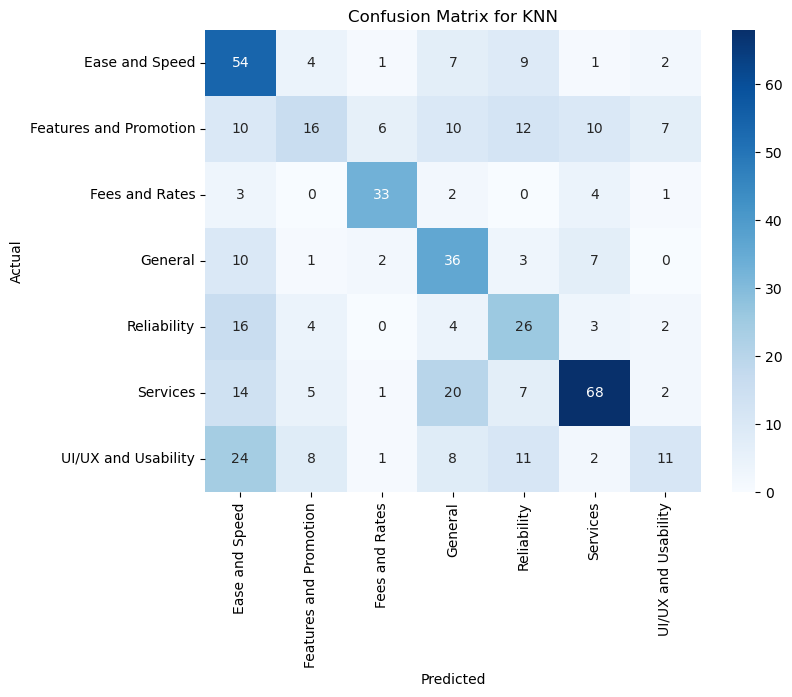

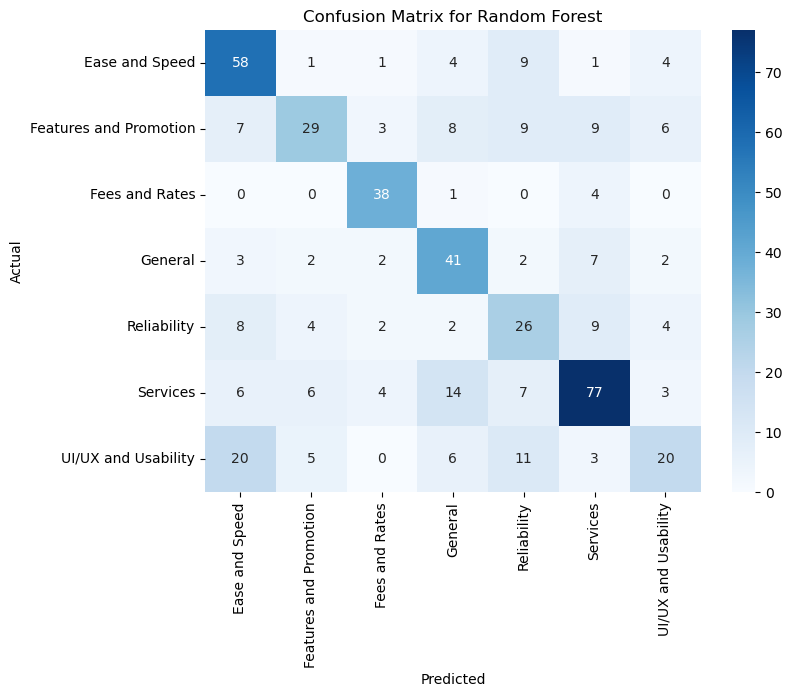

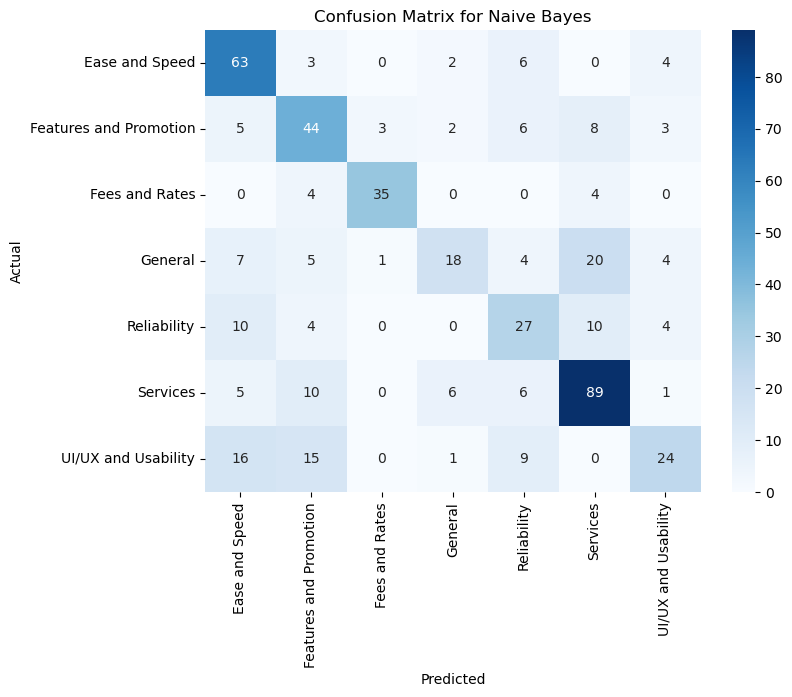

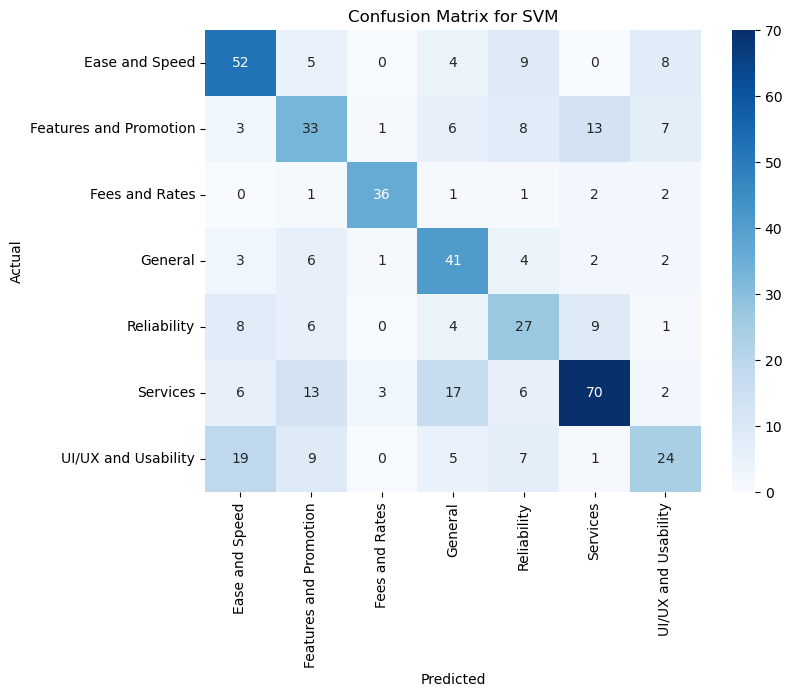

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize the classifiers
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=5),  # Add more classifiers as needed
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', random_state=42, class_weight='balanced')
}

# Vectorize data using CountVectorizer
vectorizer = CountVectorizer()

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Loop over each classifier and generate confusion matrix
for clf_name, clf in classifiers.items():
    # Vectorize training and test data
    X_train_vectorized = vectorizer.fit_transform(X_train).toarray()
    X_test_vectorized = vectorizer.transform(X_test).toarray()

    # Train the classifier
    clf.fit(X_train_vectorized, y_train)

    # Predict on the test data
    y_pred = clf.predict(X_test_vectorized)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

    # Add titles and labels
    plt.title(f"Confusion Matrix for {clf_name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


### 7. Testing

In [30]:
import numpy as np
import textwrap

# Function to predict categories for new feedback using multiple classifiers
def predict_new_feedback_multi(feedback, vectorizer, classifiers, label_encoder):
    """
    Predict categories for a given feedback using trained classifiers.

    Parameters:
    - feedback (str): New feedback to classify.
    - vectorizer: Trained TfidfVectorizer instance.
    - classifiers (dict): Dictionary of trained classifiers.
    - label_encoder: Trained LabelEncoder instance.

    Returns:
    - predictions (dict): Predicted category for each classifier.
    """
    # Preprocess and vectorize the input feedback
    feedback_vectorized = vectorizer.transform([feedback])

    predictions = {}
    for clf_name, clf in classifiers.items():
        # Predict the encoded label
        encoded_label = clf.predict(feedback_vectorized)

        # Decode the label back to the original category name
        predicted_category = label_encoder.inverse_transform(encoded_label)[0]
        predictions[clf_name] = predicted_category

    return predictions

# Prompt user to input new feedback
new_feedback = input("Masukkan New Feedback: ")

# Display the input feedback with wrapping for better formatting
print("\nInput feedback baru:")
print("\n".join(textwrap.wrap(new_feedback, width=80)))  # Wrap text at 80 characters

# Perform prediction using trained classifiers
# (tfidf_vectorizer, classifiers, and label_encoder must already be defined and trained)
predictions = predict_new_feedback_multi(new_feedback, tfidf_vectorizer, classifiers, label_encoder)

# Display prediction results
print("\nPrediksi kategori untuk feedback baru:")
for clf_name, category in predictions.items():
    print(f"{clf_name}: {category}")



Input feedback baru:
aplikasinya bagus tapi kadang fiturnya itu susah dipencet sih jadi agak
kesusahaan

Prediksi kategori untuk feedback baru:
KNN: UI/UX and Usability
Random Forest: General
Naive Bayes: Ease and Speed
SVM: Ease and Speed


In [31]:
import pandas as pd
from openpyxl import Workbook

# Function to predict categories for feedbacks in an Excel file
def predict_feedback_from_excel(input_excel, output_excel, vectorizer, classifiers, label_encoder):
    """
    Predict categories for feedbacks in an Excel file and save the results.

    Parameters:
    - input_excel (str): Path to the input Excel file with feedback data.
    - output_excel (str): Path to save the output Excel file with predictions.
    - vectorizer: Trained TfidfVectorizer instance.
    - classifiers (dict): Dictionary of trained classifiers.
    - label_encoder: Trained LabelEncoder instance.

    Returns:
    - None
    """
    # Load the input Excel file
    df = pd.read_excel(input_excel)

    # Ensure the column containing feedback is named "Feedback"
    if 'Feedback' not in df.columns:
        raise ValueError("Input Excel file must have a 'Feedback' column.")

    # Preprocess and vectorize the feedback
    feedback_vectorized = vectorizer.transform(df['Feedback'])

    # Initialize a dictionary to store predictions for each classifier
    prediction_results = {clf_name: [] for clf_name in classifiers.keys()}

    # Predict categories for each feedback
    for clf_name, clf in classifiers.items():
        encoded_labels = clf.predict(feedback_vectorized)
        decoded_labels = label_encoder.inverse_transform(encoded_labels)
        prediction_results[clf_name] = decoded_labels

    # Add predictions to the DataFrame
    for clf_name, predictions in prediction_results.items():
        df[f"Prediction ({clf_name})"] = predictions

    # Save the results to a new Excel file
    df.to_excel(output_excel, index=False)
    print(f"Hasil prediksi telah disimpan ke: {output_excel}")

# Example usage
# Pastikan `tfidf_vectorizer`, `classifiers`, dan `label_encoder` sudah dilatih sebelumnya
input_excel_path = "Data/datafeedbacknew.xlsx"  # Path ke file Excel masukan
output_excel_path = "Data/datafeedbackcategorized.xlsx"  # Path ke file Excel keluaran

predict_feedback_from_excel(
    input_excel=input_excel_path,
    output_excel=output_excel_path,
    vectorizer=tfidf_vectorizer,
    classifiers=classifiers,
    label_encoder=label_encoder
)


Hasil prediksi telah disimpan ke: Data/datafeedbackcategorized.xlsx


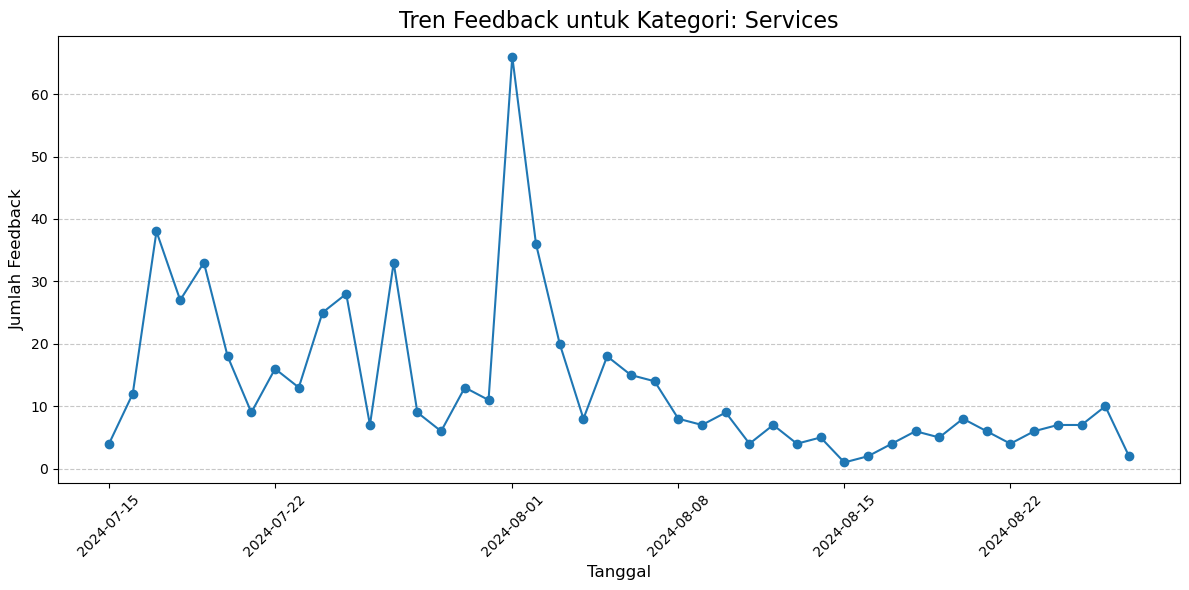

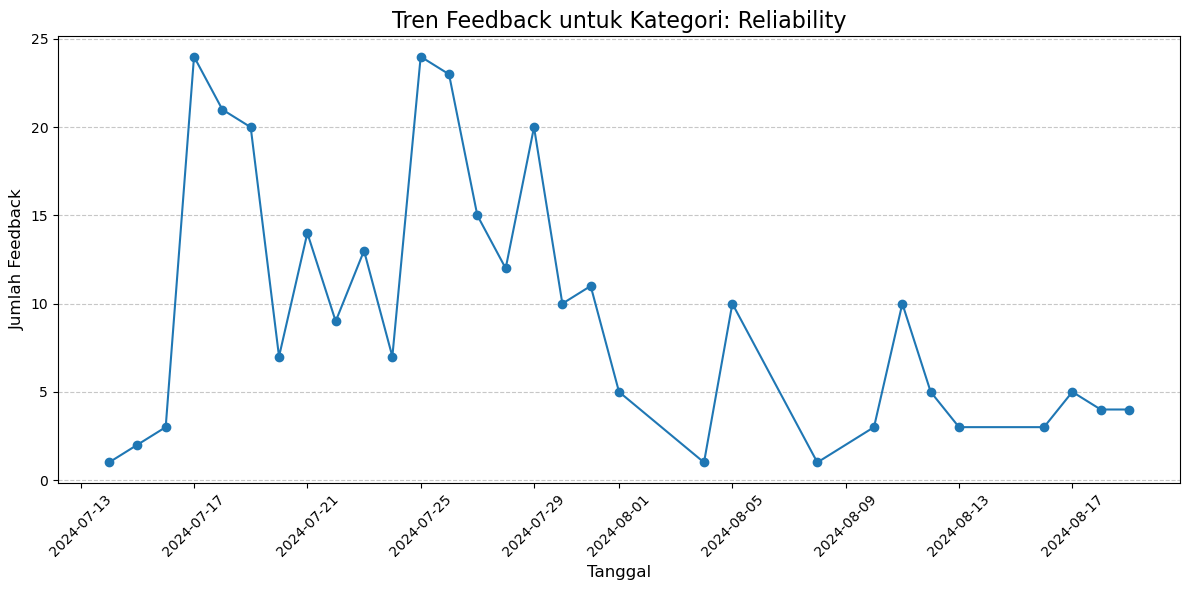

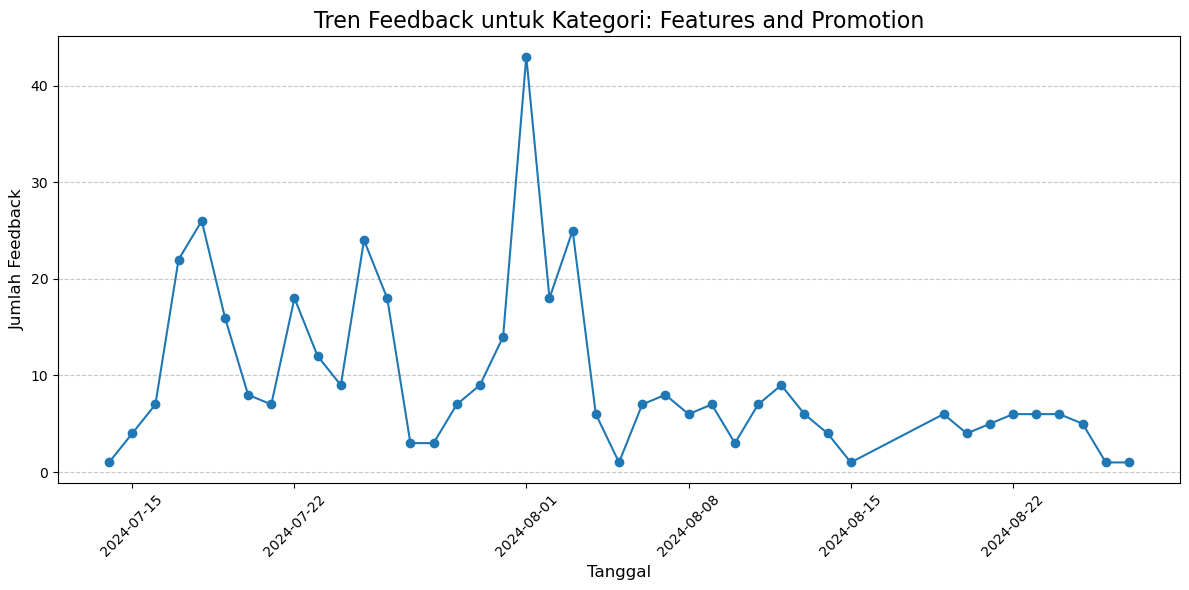

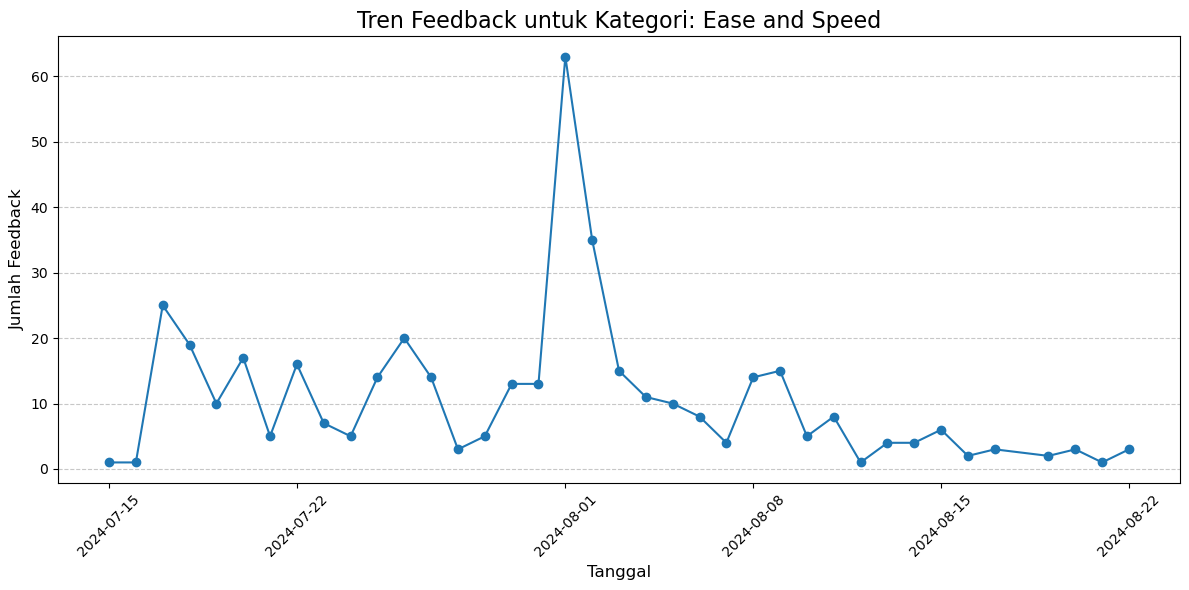

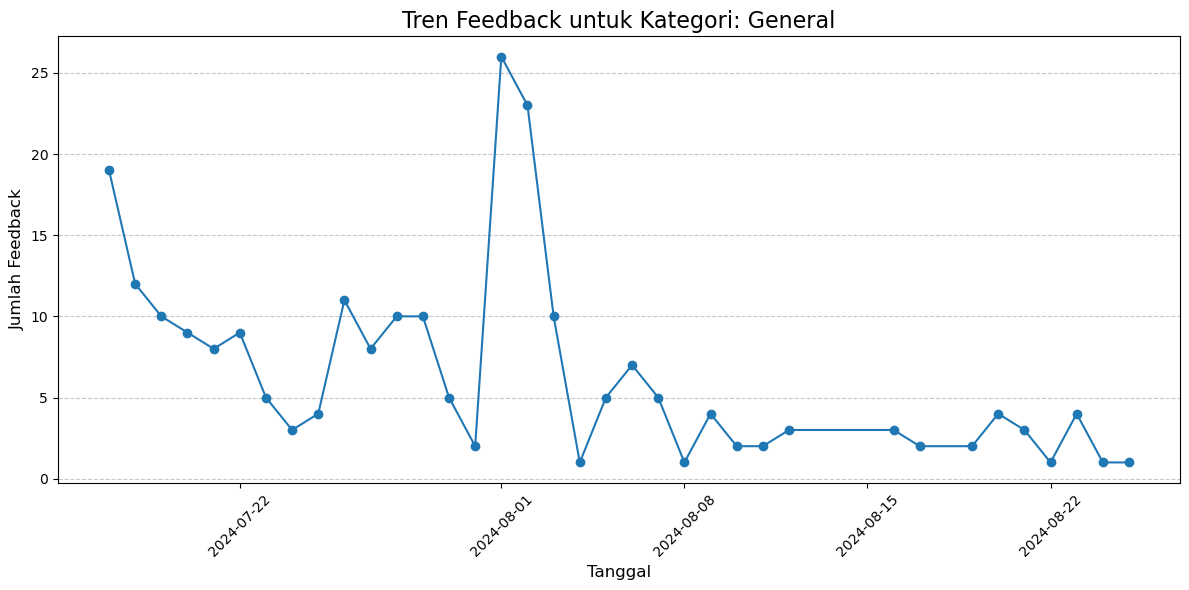

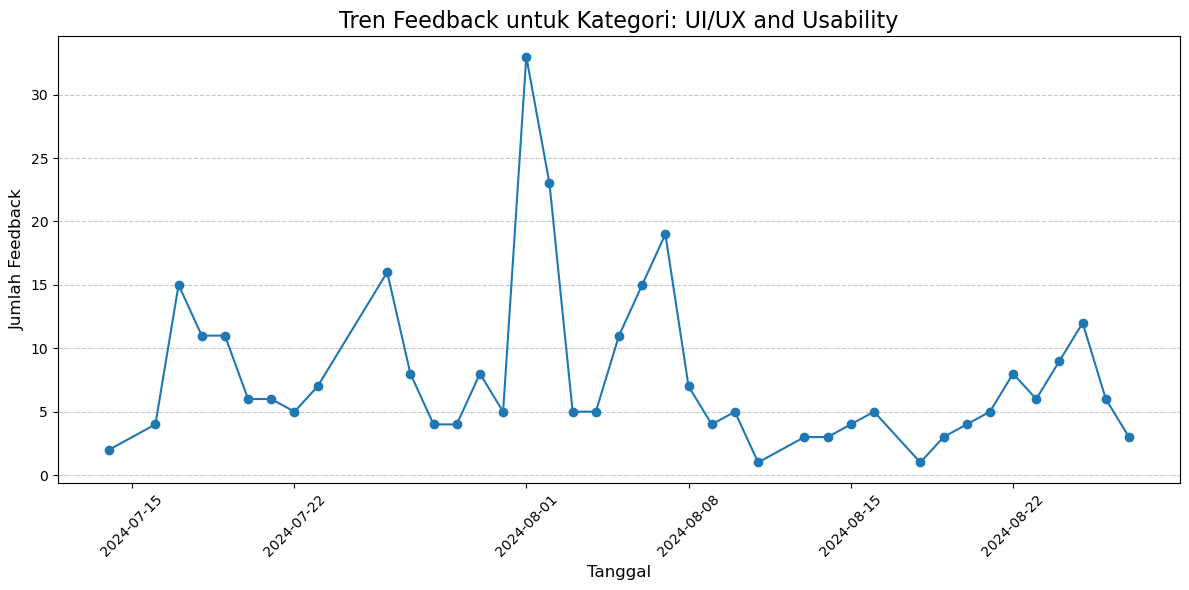

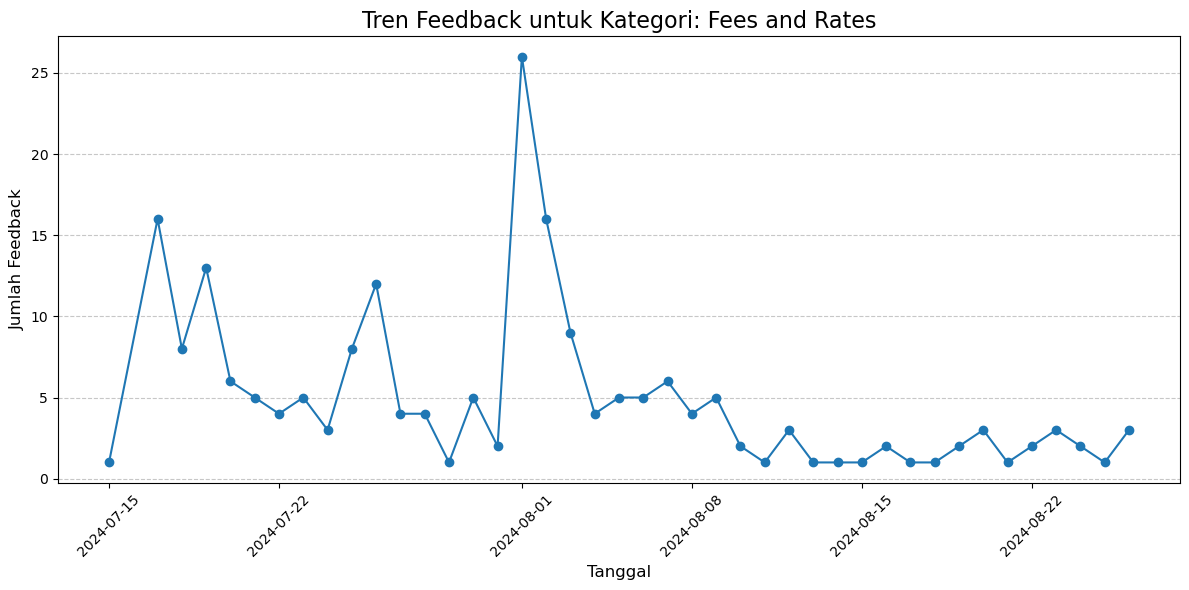

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Fungsi untuk membuat tren per kategori
def plot_category_trend(df_category, category_name):
    # Kelompokkan data berdasarkan tanggal
    trend_data = df_category.groupby('Date').size().reset_index(name='Count')
    
    # Plot tren
    plt.figure(figsize=(12, 6))
    plt.plot(trend_data['Date'], trend_data['Count'], marker='o', label=category_name)
    plt.title(f'Tren Feedback untuk Kategori: {category_name}', fontsize=16)
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('Jumlah Feedback', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot tren untuk setiap kategori
plot_category_trend(df_services, 'Services')
plot_category_trend(df_reliability, 'Reliability')
plot_category_trend(df_features, 'Features and Promotion')
plot_category_trend(df_speed, 'Ease and Speed')
plot_category_trend(df_general, 'General')
plot_category_trend(df_uiux, 'UI/UX and Usability')
plot_category_trend(df_fees, 'Fees and Rates')
